In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

import cv2


from matplotlib import pyplot as plt

import math

import random 

from keras.layers import Input, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

from keras.models import Model
from keras.optimizers import Adam

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


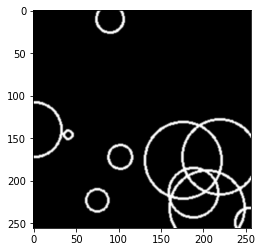

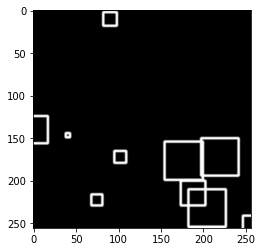

In [2]:
#-----------------------------------------------------------------------------------------------------
# Generates a single input frame (with circles based on codes ) on an prefdefine np array -----
# explisit outside codes information requires due to same codes requirement for an output frame 
def GenerateInputFrame(frame,codes):
    
    for ic in range(0, len(codes), 3):
            codex = codes[ic]
            codey = codes[ic+1]
            coder = codes[ic+2]
            r = int(coder*50)
            cv2.circle(frame, (int(codex*255),int(codey*255)), int(coder*50), (255,255,255), thickness=2)
    return frame
#-----------------------------------------------------------------------------------------------------
# Generates output single frame (recnangles ) on a predefined np array and codes  
def GenerateOutputFrame(frame,codes):
    for ic in range(0, len(codes), 3):
            codex = codes[ic]
            codey = codes[ic+1]
            coder = codes[ic+2]
            r = int(coder*50)
            cv2.rectangle(frame, (int(codex*255-r/2),int(codey*255-r/2)), (int(codex*255+r/2),int(codey*255+r/2)), (255,255,255), thickness=2) 
            
    return frame
#-----------------------------------------------------------------------------------------------------
# Generates minibatch on input(circles) and output (rectangles) frames  
def MakeBatch(batch_size):
    X = np.zeros((batch_size, 256, 256, 1))
    Y = np.zeros((batch_size, 256, 256, 1))
    for ib in range (0, batch_size):
        codes = []
        ncircles = 10
        for icir in range(0,ncircles):
            x = np.random.randint(0,10000)/10000
            y = np.random.randint(0,10000)/10000
            r = np.random.randint(0,10000)/10000
            codes.append(x)
            codes.append(y)
            codes.append(r)
            GenerateInputFrame(X[ib,:,:,:], codes)
            GenerateOutputFrame(Y[ib,:,:,:], codes)
    return X,Y

# Generator function 
def Generator(batch_size):
    while True:
        X, Y = MakeBatch(batch_size)
        yield X, Y
#-----------------------------------------------------------------------------------------------------
# Show example of circles/rectangles batch
X,Y = MakeBatch(10)   
plt.imshow(X[0,:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.show()
plt.imshow(Y[0,:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.show()  
#-----------------------------------------------------------------------------------------------------
# Generates the frame with dots
def GenerateInputFrameDots(frame,codes):
    for ic in range(0, len(codes), 2):
            codex = codes[ic]
            codey = codes[ic+1]
            cv2.circle(frame, (int(codex*255),int(codey*255)), 1, (255,255,255), thickness=1)
    return frame    
#-----------------------------------------------------------------------------------------------------
# Generates minibatch with dots  
def MakeBatchDots(batch_size):
    
    X = np.zeros((batch_size, 256, 256, 1))
    Y = np.zeros((batch_size, 256, 256, 1))
    for ib in range (0, batch_size):
        codes = []
        ndots = 2
        for idot in range(0,ndots):
            x = np.random.randint(0,10000)/10000.0
            y = np.random.randint(0,10000)/10000.0
            x=0.1+0.1*idot
            y=0.2+0.3*idot
            codes.append(x)
            codes.append(y)
            GenerateInputFrameDots(X[ib,:,:,:], codes)
            GenerateInputFrameDots(Y[ib,:,:,:], codes)
    return X,Y
#-----------------------------------------------------------------------------------------------------
# Generates the frame with simple circles
def GenerateInputFrameCirs(frame,codes):
    for ic in range(0, len(codes), 2):
            codex = codes[ic]
            codey = codes[ic+1]
            cv2.circle(frame, (int(codex*255),int(codey*255)), 15, (255,255,255), thickness=2)
    return frame    
#-----------------------------------------------------------------------------------------------------
# Generates minibatch with simple circles 
def MakeBatchCirs(batch_size):
    
    X = np.zeros((batch_size, 256, 256, 1))
    Y = np.zeros((batch_size, 256, 256, 1))
    for ib in range (0, batch_size):
        codes = []
        ndots = 2
        for idot in range(0,ndots):
            x = np.random.randint(0,10000)/10000.0
            y = np.random.randint(0,10000)/10000.0
            x=0.1+0.1*idot
            y=0.2+0.3*idot
            codes.append(x)
            codes.append(y)
            GenerateInputFrameCirs(X[ib,:,:,:], codes)
            GenerateInputFrameCirs(Y[ib,:,:,:], codes)
    return X,Y

       


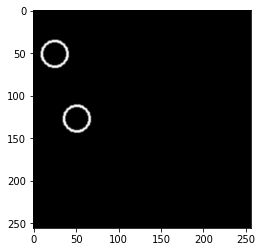

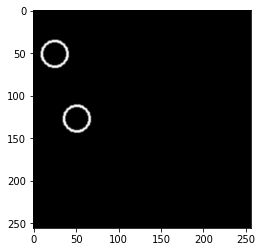

In [3]:
#MakeBatch = MakeBatchDots
MakeBatch = MakeBatchCirs


#-----------------------------------------------------------------------------------------------------
# Show example of circles/rectangles batch
X,Y = MakeBatch(10)   
plt.imshow(X[0,:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.show()
plt.imshow(Y[0,:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.show()  

In [4]:
#------ Custom Loss Function Definition ----------------------------------------

import keras.backend as K
from keras.optimizers import Adam,Adadelta
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
#    kp =K.mean(K.sum(in_gt, axis=[1,2,3]), axis=0) 
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
#    return kp*1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

In [5]:
#--------------  Autoencoder Model Definition -----------------------

input_img = Input(shape=(256, 256, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
#x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
"""
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
"""

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

##x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
##x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
##x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
##x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)


decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#autoencoder.compile(optimizer=Adadelta(lr=0.1), loss='binary_crossentropy')
autoencoder.compile(optimizer=Adadelta(lr=0.1), loss='mean_squared_error')


                          
#model.compile(optimizer=Adam(5e-5, decay=1e-6), loss= dice_p_bce, metrics=[dice_coef])
#autoencoder.compile(optimizer='adadelta', loss= dice_p_bce, metrics=[dice_coef])

autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
__________

Epoch:  0
Epoch 1/1
500/500 [==============================] - 218s 436ms/step - loss: 551.2870


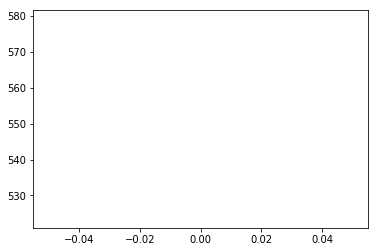

Epoch:  1
Epoch 1/1
500/500 [==============================] - 220s 439ms/step - loss: 551.2881


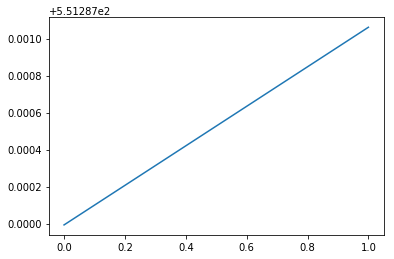

Epoch:  2
Epoch 1/1
500/500 [==============================] - 218s 436ms/step - loss: 551.2857


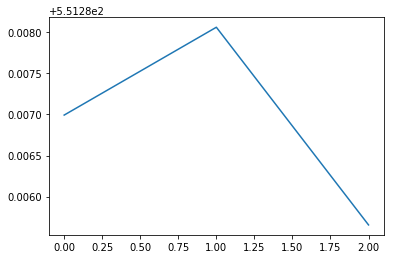

Epoch:  3
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2862


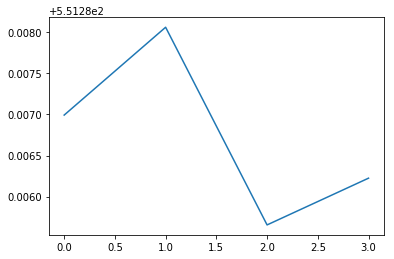

Epoch:  4
Epoch 1/1
500/500 [==============================] - 217s 435ms/step - loss: 551.2857


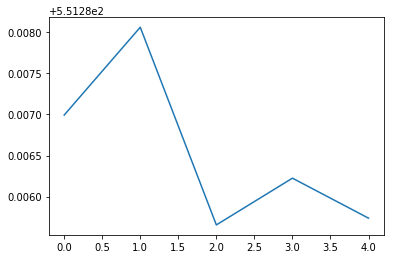

Epoch:  5
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2853


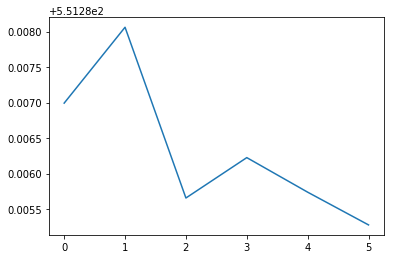

Epoch:  6
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


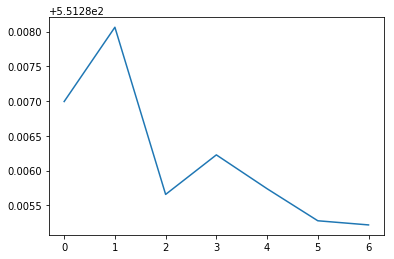

Epoch:  7
Epoch 1/1
500/500 [==============================] - 217s 435ms/step - loss: 551.2852


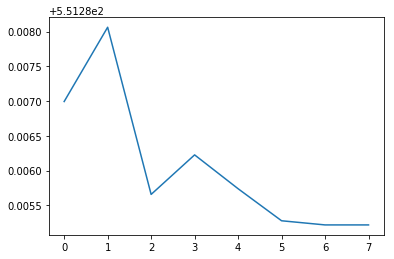

Epoch:  8
Epoch 1/1
500/500 [==============================] - 217s 435ms/step - loss: 551.2852


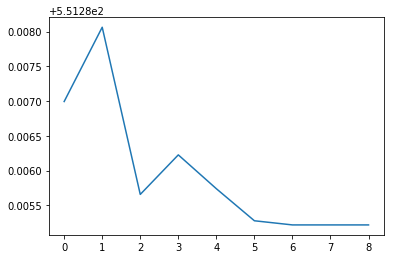

Epoch:  9
Epoch 1/1
500/500 [==============================] - 218s 436ms/step - loss: 551.2852


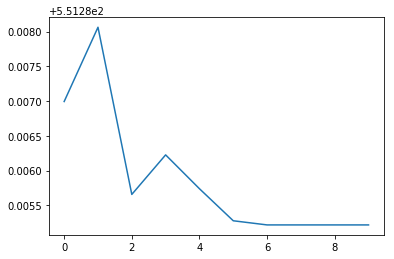

Epoch:  10
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


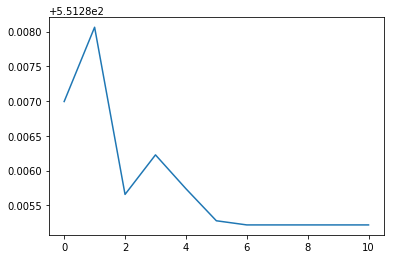

Epoch:  11
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


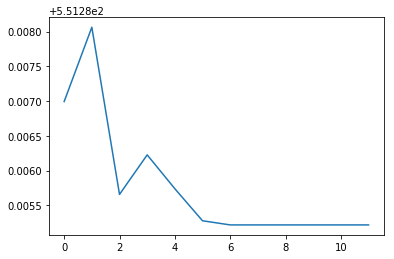

Epoch:  12
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


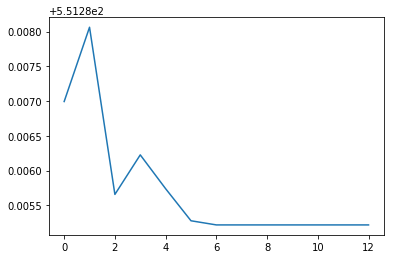

Epoch:  13
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


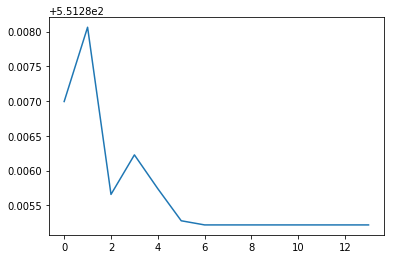

Epoch:  14
Epoch 1/1
500/500 [==============================] - 217s 435ms/step - loss: 551.2852


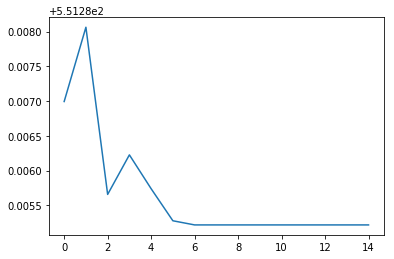

Epoch:  15
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


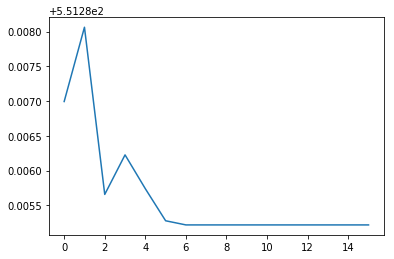

Epoch:  16
Epoch 1/1
500/500 [==============================] - 217s 435ms/step - loss: 551.2852


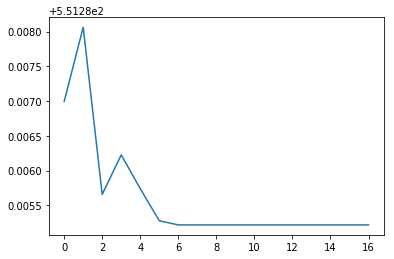

Epoch:  17
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


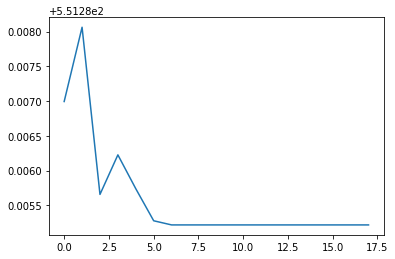

Epoch:  18
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


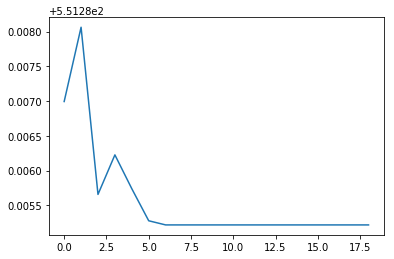

Epoch:  19
Epoch 1/1
500/500 [==============================] - 218s 435ms/step - loss: 551.2852


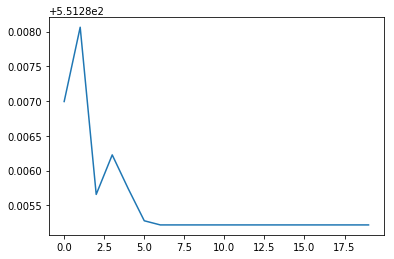

In [11]:
#  Train AutoEncoder and show some predicted results
#results = autoencoder.fit_generator(Generator(batch_size = 25), steps_per_epoch = 500, epochs = 1)

EPOCHS = 20
loss_list = []
for i in range (0,EPOCHS):
    print("Epoch: ",i)
    results = autoencoder.fit_generator(Generator(batch_size = 25), steps_per_epoch = 500, epochs = 1)
    loss_list.append(results.history['loss'])
    plt.plot(loss_list, label = 'loss')
    plt.show()

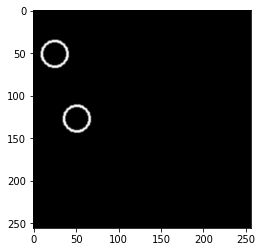

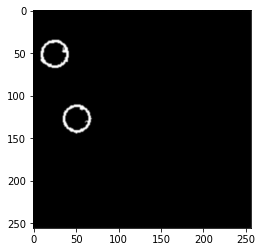

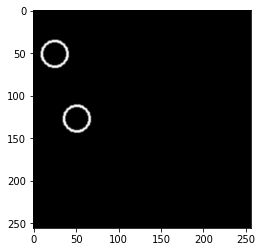

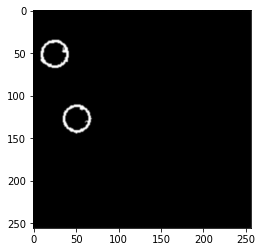

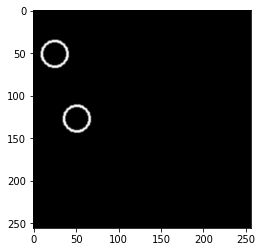

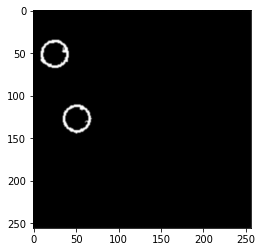

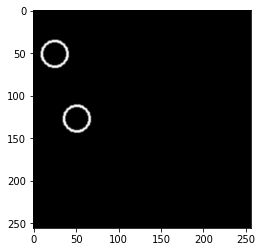

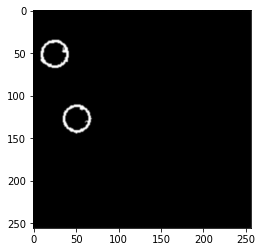

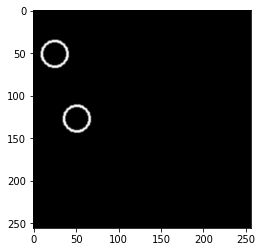

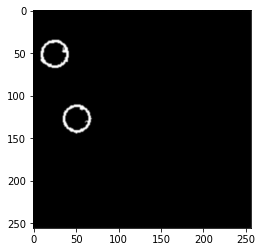

In [13]:
X,Y = MakeBatch(5)   
predictions = autoencoder.predict(X) 

for i in range(0,5):
    plt.imshow(X[i,:,:,0], cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    plt.imshow(predictions[i,:,:,0], cmap = 'gray', interpolation = 'bicubic')
    plt.show()